In [11]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import stan
import arviz as az

import nest_asyncio
nest_asyncio.apply()

In [12]:
# Reading in example response times (RT) data
df = pd.read_csv('sample_response_times.csv', delimiter=';')

In [13]:
# Explore the top five rows
df.head()

,rt,choice,condition
0,0.477,1.0,1.0
1,0.600,1.0,1.0
2,0.500,0.0,1.0
3,0.416,1.0,1.0
4,0.435,1.0,1.0


In [14]:
response_times = df['rt'].to_numpy()
choices = df['choice'].to_numpy()
conditions = df['condition'].to_numpy()

In [15]:
program_code = """

data {
    int<lower=1> N;
    array[N] real<lower=0> y;
    array[N] int<lower=1, upper=2> condition;
    array[N] int<lower=0, upper=1> choice;
}

parameters {
    // Your code here
    real<lower=0> v1;
    real<lower=0> v2;
    real<lower=0> a;
    real<lower=0, upper=1> beta;
    real<lower=0> tau;
}

model {
    // Priors
    // Your code here
    v1 ~ gamma(3, 1);
    v2 ~ gamma(3, 1);
    a ~ gamma(3, 1);
    beta ~ beta(2, 2);
    tau ~ gamma(2, 1);

    // Likelihood
    for (n in 1:N) {
        // Condition 1
        if (condition[n] == 1) {
            if (choice[n] == 1) {
                 // Your code here
                 y[n] ~ wiener(a, tau, beta, v1);
            }
            else {
                 // Your code here
                 y[n] ~ wiener(a, tau, 1-beta, -v1);
            }
        }
        // Condition 2
        if (condition[n] == 2) {
            if (choice[n] == 1) {
                // Your code here
                y[n] ~ wiener(a, tau, beta, v2);
            }
            else {
                 // Your code here
                 y[n] ~ wiener(a, tau, 1-beta, -v2);
            }
        }
    }
}
"""

In [16]:
# Prepare data in Stan friendly format
data_dict = {
    'N': 300,
    'y': response_times, 
    'condition': conditions.astype(int),
    'choice': choices.astype(int)
}

# Compile model
model = stan.build(program_code, data=data_dict)

Building...



Building: found in cache, done.

In [17]:
# Posterior inference using MCMC
fit = model.sample(num_chains=4, num_warmup=1000, num_samples=2500)

Sampling:   0%
Sampling:   0% (1/14000)
Sampling:   0% (2/14000)
Sampling:   0% (3/14000)
Sampling:   0% (4/14000)
Sampling:   1% (103/14000)
Sampling:   1% (203/14000)
Sampling:   2% (303/14000)
Sampling:   3% (403/14000)
Sampling:   4% (502/14000)
Sampling:   4% (602/14000)
Sampling:   5% (701/14000)
Sampling:   6% (801/14000)
Sampling:   6% (900/14000)
Sampling:   7% (1000/14000)
Sampling:   8% (1100/14000)
Sampling:   9% (1200/14000)
Sampling:   9% (1300/14000)
Sampling:  10% (1400/14000)
Sampling:  11% (1500/14000)
Sampling:  11% (1600/14000)
Sampling:  12% (1700/14000)
Sampling:  13% (1800/14000)
Sampling:  14% (2000/14000)
Sampling:  16% (2300/14000)
Sampling:  20% (2800/14000)
Sampling:  24% (3300/14000)
Sampling:  28% (3900/14000)
Sampling:  35% (4900/14000)
Sampling:  44% (6200/14000)
Sampling:  56% (7900/14000)
Sampling:  68% (9500/14000)
Sampling:  76% (10600/14000)
Sampling:  81% (11400/14000)
Sampling:  84% (11800/14000)
Sampling:  86% (12000/14000)
Sampling:  88% (12300/

In [18]:
# Extract samples
df = fit.to_frame()

In [19]:
# Posterior summary statistics
az.summary(fit)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v1,2.652,0.258,2.162,3.144,0.003,0.002,6722.0,6162.0,1.0
v2,0.515,0.180,0.194,0.856,0.002,0.001,6980.0,5142.0,1.0
a,0.851,0.026,0.802,0.899,0.000,0.000,6148.0,7000.0,1.0
beta,0.511,0.021,0.472,0.550,0.000,0.000,5976.0,6854.0,1.0
tau,0.397,0.003,0.391,0.402,0.000,0.000,5810.0,5774.0,1.0


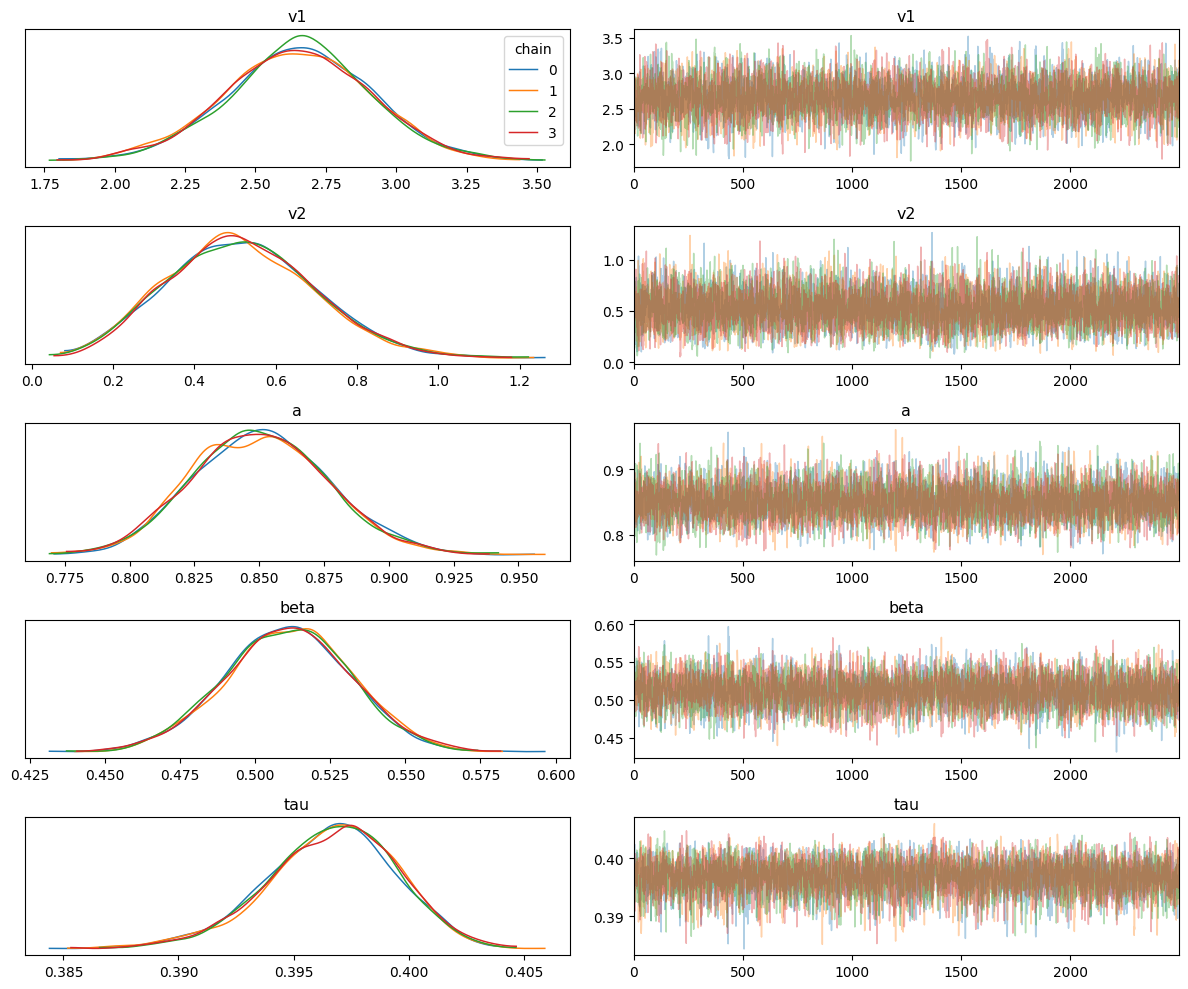

In [20]:
# Traceplots 
f = az.plot_trace(fit, compact=False, legend=True)
plt.tight_layout()